# <font color="green">CVC Project</font>

## <font color="gray">Mobile Robot Orientation and Position using QR Code</font>

## For mobile robots, a QR code (that has the coordinates of a point) fixed on the ground can be an easy way to determine the robot's position when it scans it. However, determining the robot's orientation quite straight forward. <font color="blue">So the core of our project is to determine the orientation of our robot in degrees.</font>

## Note that the orientation of the robot is calculated in degrees and is measured from the vertical axis in clockwise direction. <font color="blue">(When the robot scans the QR code in the normal position, its orientation is zero degrees).<font>

<img src="orientations.png">

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pyzbar.pyzbar as pyzbar
import cv2
import numpy as np

%matplotlib inline

from math import pow, sqrt, atan, pi

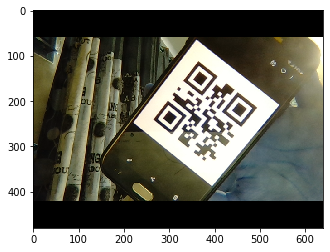

In [2]:
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    
    plt.imshow(frame)
    
    # find the barcodes in the image and decode each of the barcodes
    barcode = pyzbar.decode(frame)
    
    if len(barcode) > 0:
        cap.release()
        break

1


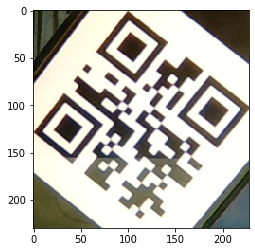

In [3]:
print(len(barcode))

# extract the bounding box location of the barcode and crop the image
(x, y, w, h) = barcode[0].rect
img_gray = frame[y:y+w, x:x+h]
    
plt.imshow(img_gray, cmap="gray")

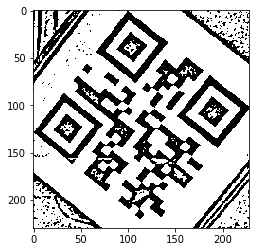

In [4]:
# Convert to gray
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)

# Threshold
img_gray = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
            cv2.THRESH_BINARY,11,2)

plt.imshow(img_gray, cmap="gray")

In [5]:
# Get labels and stats
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(img_gray)

print(stats)

[[    0     0   228   230 15302]
 [    0     0     5    54   177]
 [    6     0    17    47   398]
 [   24     0    18    21   161]
 [   44     0     1     1     1]
 [    0     0    54    70   201]
 [    0     0   228   230 27087]
 [  166     1     1     1     1]
 [  168     0    60    49  1364]
 [   43     2     1     1     1]
 [   46     2     1     1     1]
 [   43     4     1     1     1]
 [   45     4     1     1     1]
 [   37     6     6     7    11]
 [   77    11    55    56  1106]
 [   23    24     6     6    11]
 [   22    31     1     1     1]
 [   96    33    17    15   101]
 [  106    32     1     1     1]
 [  210    37     1     2     2]
 [   14    39     3     4     6]
 [   10    46     2     2     3]
 [    7    48     2     6    10]
 [  226    50     1     1     1]
 [    5    52     1     3     3]
 [    0    56     5     6    13]
 [  161    57     1     1     1]
 [  154    59    15    11    59]
 [  137    63     5     4     9]
 [  170    62     1     2     2]
 [  170   

## We use connected components analysis to get the position of the three squares of the QR code, so we need to threshold to their areas.
## <font color="blue">Note that this step needs only to be done once, since the camera will always be fixed in a specific position on the robot.</font>

## <font color="red">* Set Area Threshold Here *</font>

In [8]:
# Squares area threshold
min_area = 1080
max_area = 1133

## <font color="red"> **************************************** </font>

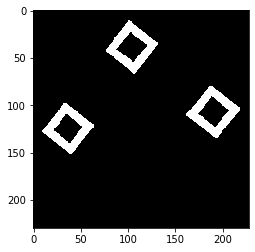

In [9]:
# Create copy of stats and image
image = np.zeros(img_gray.shape, dtype="uint8")
stats_cp = np.copy(stats)

# List to store each square's center point
squares = list()
    
# Loop on each label to draw a rectangle on it
for j in range(len(stats)):
        
    # Skip if it is background or if small or big region
    if stats[j, cv2.CC_STAT_AREA] < min_area or stats[j, cv2.CC_STAT_AREA] > max_area:
        continue
    
    # Get square center point
    x = int(stats[j, cv2.CC_STAT_LEFT] + (stats[j, cv2.CC_STAT_WIDTH] / 2))
    y = int(stats[j, cv2.CC_STAT_TOP] + (stats[j, cv2.CC_STAT_HEIGHT] / 2))
    # Add the square center point to the list
    squares.append((x, y))
        
    # Get the points of the small square
    pts = np.where(labels_im == j)
    # draw it
    image[pts] = 255

plt.imshow(image, cmap="gray")

In [10]:
# List to store line point and its length
line_len = list()

# calculate the length of the lines
for i in range(len(squares)):
    x1, y1 = squares[i]

    for j in range(i+1, len(squares)):
        x2, y2 = squares[j]
        
        # Calculate length
        line = int(sqrt(pow(x2-x1, 2) + pow(y2-y1, 2)))
        
        line_len.append([(x1, y1), (x2, y2), (line)])

In [11]:
# Find longest line
max_line = line_len[0]

if max_line[2] < line_len[1][2] or max_line[2] < line_len[2][2]:
    if line_len[1][2] < line_len[2][2]:
        max_line = line_len[2]
    else:
        max_line = line_len[1]
        
x1, y1 = max_line[0]
x2, y2 = max_line[1]

# Find coordinates of the unused square
i1 = squares.index(max_line[0])
i2 = squares.index(max_line[1])
i3 = 0

for i in range(len(squares)):
    if i != i1 and i != i2:
        i3 = i
        break
                
x3, y3 = squares[i3]

# Midpoint of longest line
ym = int(round((y2 + y1) / 2))
xm = int(round((x2 + x1) / 2))

In [12]:
# Calculate slope
# If longest line is horizontal, angle = 135 or 315
if (y1-y2) == 0:
    if y3 > ym:
        angle = 315
    else:
        angle = 135
    
# If longest line is vertical, angle = 45 or 225
elif (x2-x1) ==0:
    if x3 > xm:
        angle = 45        
    else:
        angle = 225
    
else:
    m = (x1-x2)/(y2-y1)
    angle = int(round(atan(m) * 180 / pi))
    
    if x3 > xm:
        angle += (180-45)
    else:
        angle -= 45
        
    angle = (angle + 360) % 360
    
print(angle)
print(barcode[0].data)

38
b'(2, 7)'
